In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
plt.style.use('ggplot')

## Load Data

In [3]:
data_path = "./per_station.xlsx"
data = pd.read_excel(data_path)

# Extract the 'sc4' column data
sc_data = data['sc4'].values

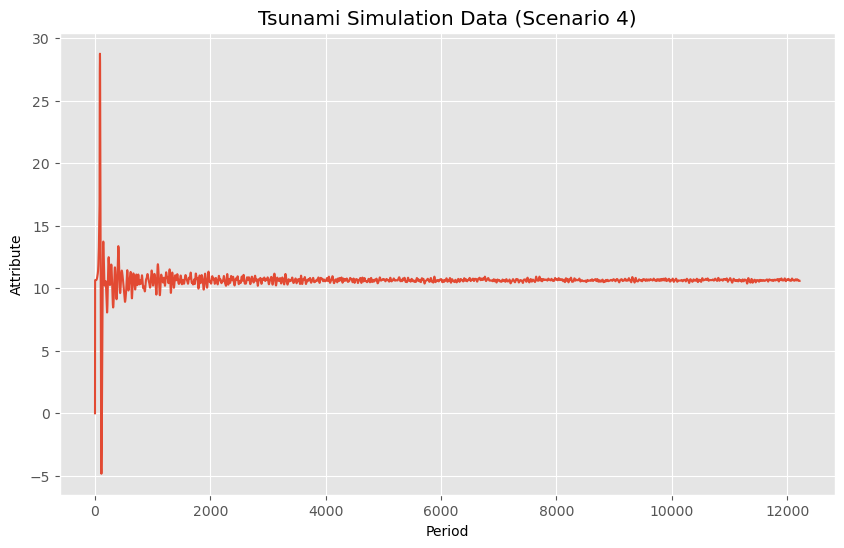

In [4]:
# Generate dummy data
series_data = sc_data[:]

# Plot the dummy data
plt.figure(figsize=(10, 6))
plt.plot(series_data, linestyle='-')
plt.title('Tsunami Simulation Data (Scenario 4)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.grid(True)
plt.show()

## Prepare Data

In [5]:
def prepare_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Prepare the data
X, y = prepare_data(series_data, sequence_length)

# Convert to PyTorch tensors
X_tensor = torch.Tensor(X).unsqueeze(-1)  # Add an extra dimension for the input channel
y_tensor = torch.Tensor(y).unsqueeze(-1)

## LSTM Experiment

#### Build Model

In [6]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StackedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Define a list of LSTM layers
        self.lstms = nn.ModuleList([nn.LSTM(input_size if i == 0 else hidden_size, 
                                             hidden_size, 
                                             num_layers=1,  # Each layer in the stack is a single layer LSTM
                                             batch_first=True) for i in range(num_layers)])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden and cell states for each layer
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through each LSTM layer in the stack
        for i, lstm in enumerate(self.lstms):
            out, _ = lstm(x if i == 0 else out, (h0[i:i+1], c0[i:i+1]))  # Pass input or previous layer's output to the next layer
            out = self.dropout(out)  # Apply dropout
        out = self.fc(out[:, -1, :])  # Take the output of the last time step and pass it through the fully connected layer
        return out

# Define model parameters
input_size = 1
hidden_size = 32
num_layers = 2  # Set the number of layers in the LSTM stack
output_size = 1

# Instantiate the model
model = StackedLSTM(input_size, hidden_size, num_layers, output_size)
print(model)

StackedLSTM(
  (lstms): ModuleList(
    (0): LSTM(1, 32, batch_first=True)
    (1): LSTM(32, 32, batch_first=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


#### Train Model

In [7]:
# Define training parameters
num_epochs = 100
learning_rate = 0.001
batch_size = 32
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Store losses
losses = []

# Initialize the best loss as infinity
best_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    
    epoch_loss = 0.0
    
    # Shuffle the data and split into batches
    indices = torch.randperm(len(X_tensor))
    X_shuffled = X_tensor[indices]
    y_shuffled = y_tensor[indices]
    
    for i in range(0, len(X_tensor), batch_size):
        
        # Forward pass
        outputs = model(X_shuffled[i:i+batch_size])
        loss = criterion(outputs, y_shuffled[i:i+batch_size])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for the epoch
        epoch_loss += loss.item()
    
    # Average epoch loss
    epoch_loss /= (len(X_tensor) / batch_size)
    losses.append(epoch_loss)
    
    # Save the model if this epoch's loss is the best we've seen so far
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), 'best_model.pth')

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {epoch_loss:.6f}')

Epoch [1/100], MSE Loss: 24.861422
Epoch [2/100], MSE Loss: 3.678482
Epoch [3/100], MSE Loss: 3.712422
Epoch [4/100], MSE Loss: 3.583410
Epoch [5/100], MSE Loss: 3.479037
Epoch [6/100], MSE Loss: 3.380413
Epoch [7/100], MSE Loss: 3.276984
Epoch [8/100], MSE Loss: 3.278864
Epoch [9/100], MSE Loss: 3.231227
Epoch [10/100], MSE Loss: 3.053139
Epoch [11/100], MSE Loss: 2.976450
Epoch [12/100], MSE Loss: 2.791019
Epoch [13/100], MSE Loss: 2.743812
Epoch [14/100], MSE Loss: 2.682777
Epoch [15/100], MSE Loss: 2.469836
Epoch [16/100], MSE Loss: 2.353108
Epoch [17/100], MSE Loss: 2.207319
Epoch [18/100], MSE Loss: 2.120218
Epoch [19/100], MSE Loss: 2.024435
Epoch [20/100], MSE Loss: 1.876646
Epoch [21/100], MSE Loss: 1.783938
Epoch [22/100], MSE Loss: 1.669995
Epoch [23/100], MSE Loss: 1.580861
Epoch [24/100], MSE Loss: 1.488414
Epoch [25/100], MSE Loss: 1.412696
Epoch [26/100], MSE Loss: 1.322484
Epoch [27/100], MSE Loss: 1.239448
Epoch [28/100], MSE Loss: 1.130395
Epoch [29/100], MSE Loss: 1.

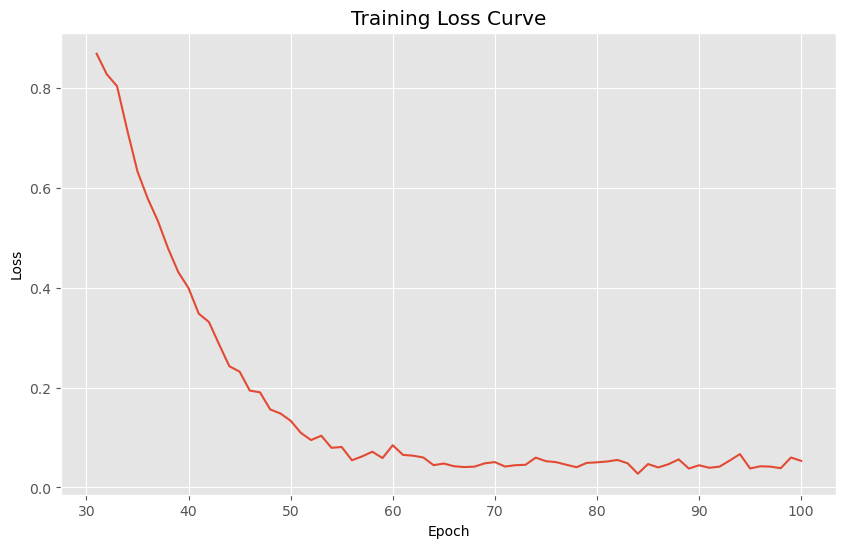

In [8]:
# Plot learning curve
offset = 30

plt.figure(figsize=(10, 6))
plt.plot(range(offset+1, num_epochs+1), losses[offset:], linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#### Evaluate Model

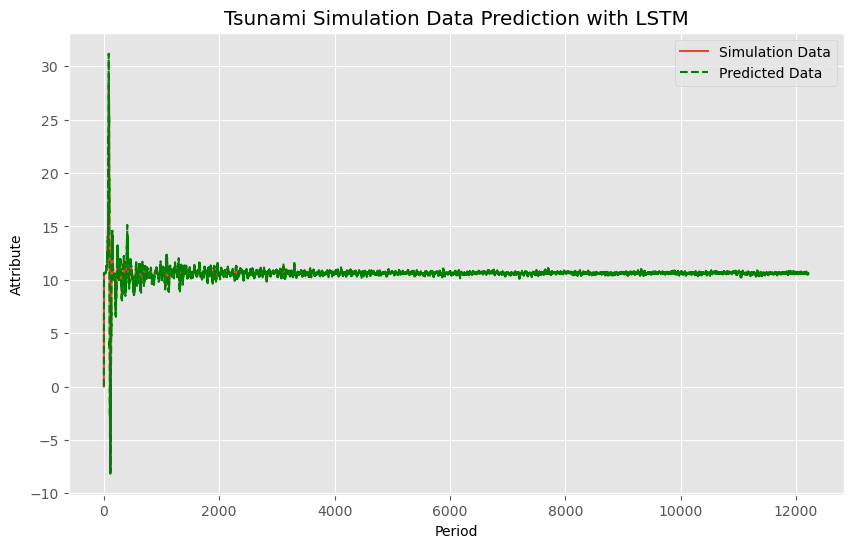

In [9]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

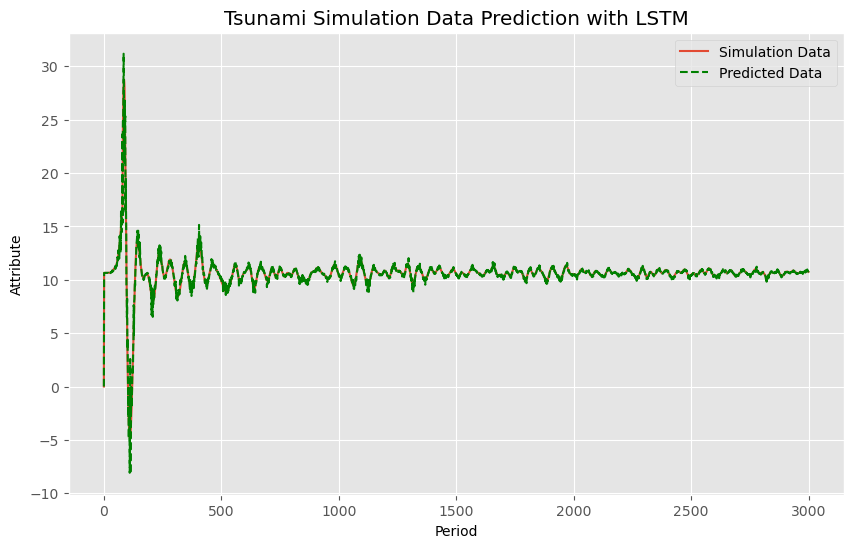

In [10]:
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.04114173530161083
Mean Absolute Error (MAE): 0.06604662548103661


## Test S1, S2, S3

In [12]:
sc_data = data['sc1'].values
series_data = sc_data[:]

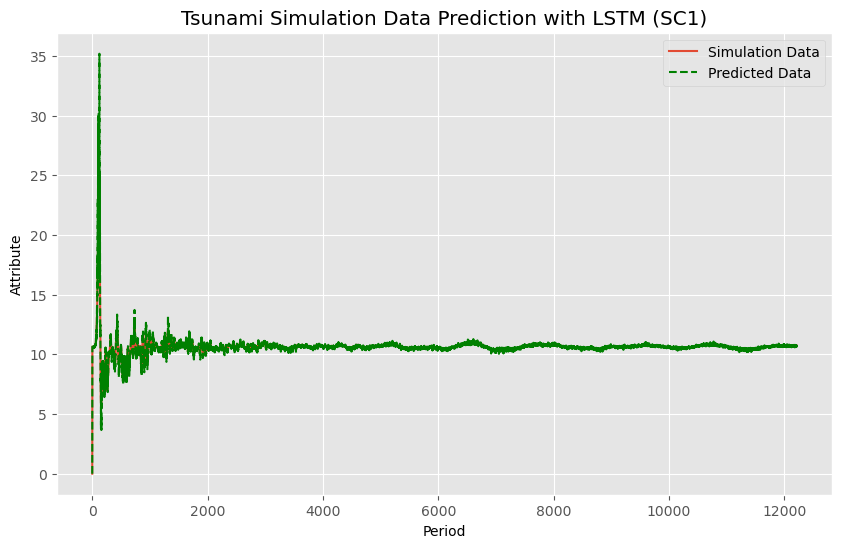

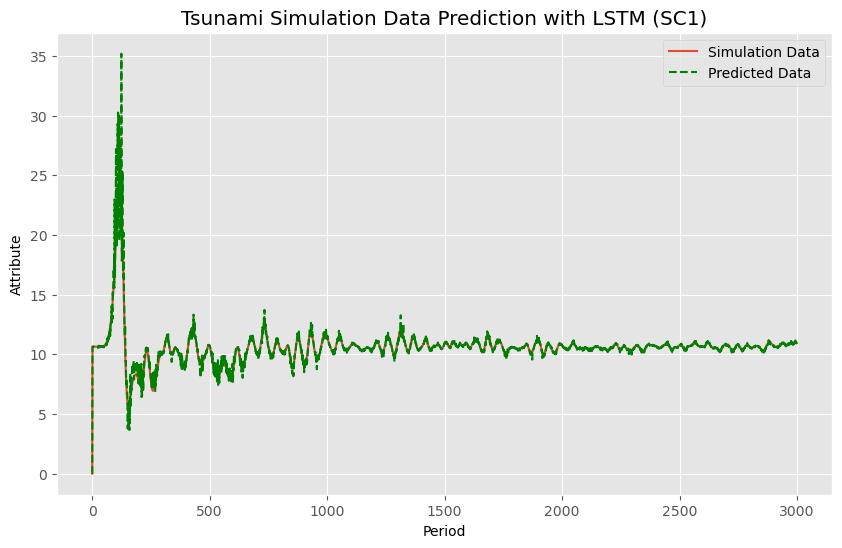

In [13]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC1)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC1)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC1 Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC1 Mean Absolute Error (MAE):", mae)

SC1 Mean Squared Error (MSE): 0.06784266567299448
SC1 Mean Absolute Error (MAE): 0.07706567326788534


In [15]:
sc_data = data['sc2'].values
series_data = sc_data[:]

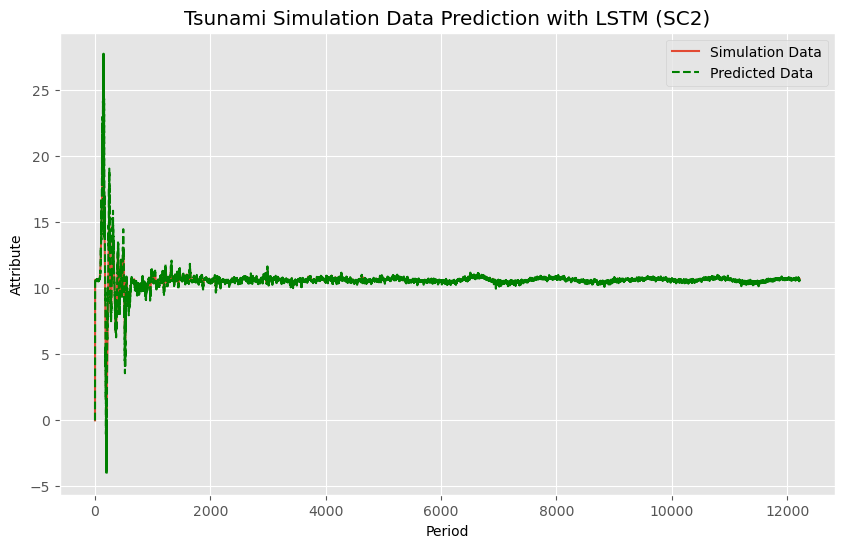

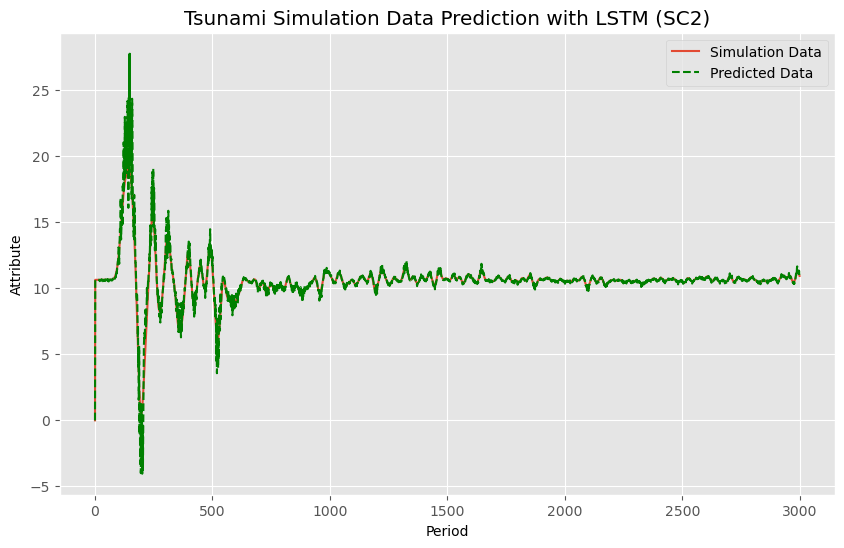

In [16]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC2)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC2)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC2 Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC2 Mean Absolute Error (MAE):", mae)

SC2 Mean Squared Error (MSE): 0.09148055405839736
SC2 Mean Absolute Error (MAE): 0.08199038627955463


In [18]:
sc_data = data['sc3'].values
series_data = sc_data[:]

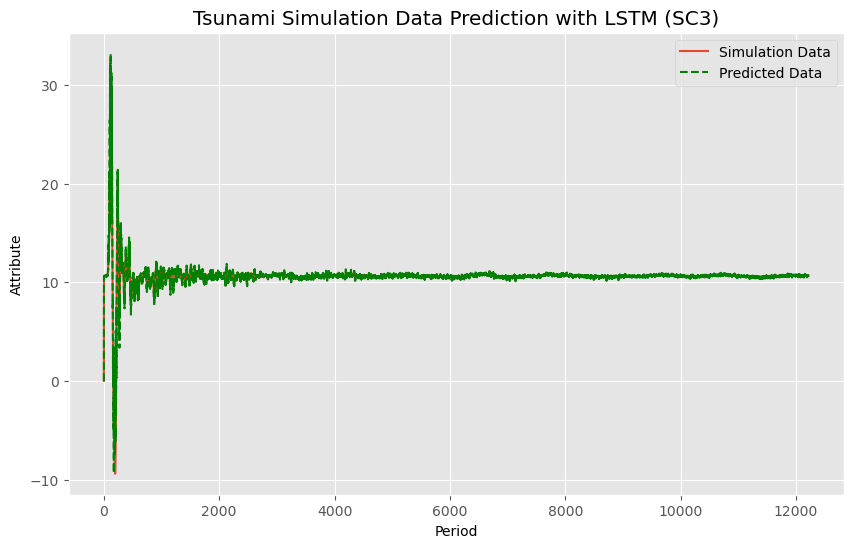

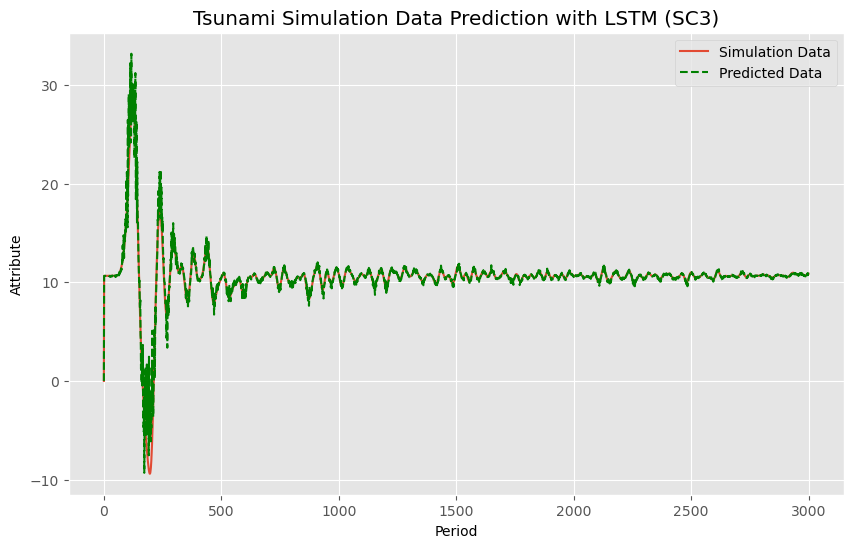

In [19]:
# Prepare the first sequence for prediction
first_sequence = torch.FloatTensor(series_data[:sequence_length]).unsqueeze(0).unsqueeze(-1)

# Make predictions for the entire time series
with torch.no_grad():
    future_periods = len(series_data) - sequence_length
    future_data = series_data[:sequence_length].tolist()

    for i in range(future_periods):
        pred = model(first_sequence)
        future_data.append(pred.item())
        
        # Update the first sequence for the next prediction
        # first_sequence = torch.cat((first_sequence[:, 1:, :], pred.unsqueeze(-1)), dim=1)
        first_sequence = torch.cat((first_sequence[:, 1:, :], torch.tensor([[series_data[i+sequence_length]]], dtype=torch.float32).unsqueeze(0)), dim=1)
        
# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data)), series_data, linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data)), future_data, linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC3)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

# Plot the original and predicted simulation data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(series_data[:3000])), series_data[:3000], linestyle='-', label='Simulation Data')
plt.plot(np.arange(len(series_data[:3000])), future_data[:3000], linestyle='--', color='g', label='Predicted Data')
plt.title('Tsunami Simulation Data Prediction with LSTM (SC3)')
plt.xlabel('Period')
plt.ylabel('Attribute')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC3 Mean Squared Error (MSE):", mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(series_data[sequence_length:], future_data[sequence_length:])
print("SC3 Mean Absolute Error (MAE):", mae)

SC3 Mean Squared Error (MSE): 0.1875271379312394
SC3 Mean Absolute Error (MAE): 0.09725114535152093


---